## Obtain data directly through the API.

In [83]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "redwankarimsony/heart-disease-data",
    "heart_disease_uci.csv"
)

df.head()

/var/folders/9m/5d8c43f92v7g10d35slh_v0h0000gn/T/ipykernel_12525/2909695717.py:4: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [84]:
df.shape

(920, 16)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [86]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


## data pre-processing

In [87]:
# Objective binarization: num > 0 -> 1 (disease present), else 0 (no disease)
df["target"] = (df["num"] > 0).astype(int)

# Delete only the marked columns; retain the useful data.
df_model = df.drop(columns=["id", "num"], errors="ignore").copy()


# Explicitly convert the "true category column" to "category" dtype.
categorical_like = ["sex","cp","fbs","restecg","exang","slope","ca","thal"]
for c in categorical_like:
    if c in df_model.columns:
        df_model[c] = df_model[c].astype("category")

# Automated classification of numerical/ categorical values
numeric_cols = df_model.select_dtypes(include=["int64","float64"]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != "target"]
categorical_cols = [c for c in df_model.columns if c not in numeric_cols + ["target"]]

### The numerical features and categorical features are respectively cleaned, completed, encoded, and finally integrated into a training data matrix that is suitable for the model.

In [88]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median", add_indicator=True))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)) 
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

In [89]:
from sklearn.model_selection import train_test_split
# 6) Divide the training/test set（8:2）
X = df_model.drop(columns=["target"])
y = df_model["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [90]:
from sklearn.base import clone
## The validation set (train/validation) uses its own preprocessor.
## The final training + test set (train/test) uses another set of preprocessors
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)
## 
preprocess_tr   = clone(preprocess).fit(X_tr)  
X_tr_proc       = preprocess_tr.transform(X_tr)
X_val_proc      = preprocess_tr.transform(X_val)

# For holdout testing / distributed training (fit only on X_train)
preprocess_train = clone(preprocess).fit(X_train)
X_train_proc     = preprocess_train.transform(X_train)
X_test_proc      = preprocess_train.transform(X_test)

## XGboost

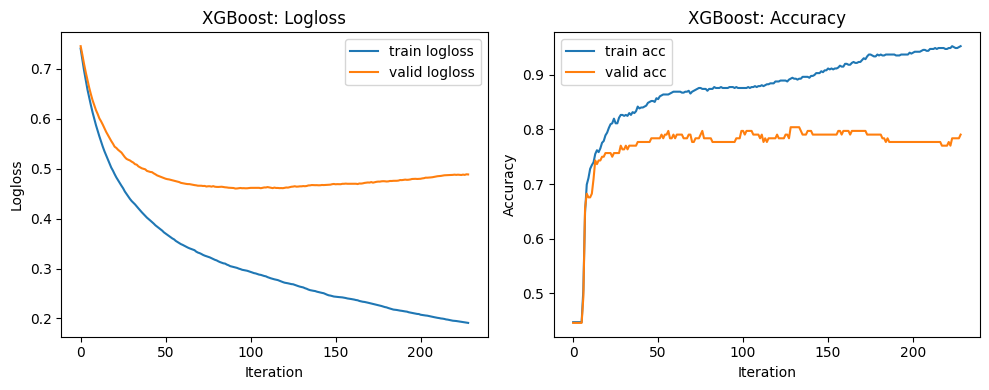

In [91]:
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt

pos = y_train.sum()
neg = len(y_tr) - pos
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

# 1) 定义并包含两个评估指标
XGBoost = XGBClassifier(
    n_estimators=2000,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric=["logloss","error"],
    scale_pos_weight=scale_pos_weight,
    early_stopping_rounds=100,
    n_jobs=-1, 
    random_state=42
)

XGBoost.fit(
    X_tr_proc, y_tr,
    eval_set=[(X_tr_proc, y_tr), (X_val_proc, y_val)],
    verbose=False
)

# 3) Retrieve the training process records (note: use the method evals_result(), not attribute)
ev = XGBoost.evals_result()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Logloss 
axes[0].plot(ev['validation_0']['logloss'], label='train logloss')
axes[0].plot(ev['validation_1']['logloss'], label='valid logloss')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Logloss')
axes[0].set_title('XGBoost: Logloss')
axes[0].legend()

# Accuracy 
train_acc = 1 - np.array(ev['validation_0']['error'])
valid_acc = 1 - np.array(ev['validation_1']['error'])
axes[1].plot(train_acc,  label='train acc')
axes[1].plot(valid_acc,  label='valid acc')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('XGBoost: Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

## LightGBM（non-distributed）

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 325, number of negative: 263
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM

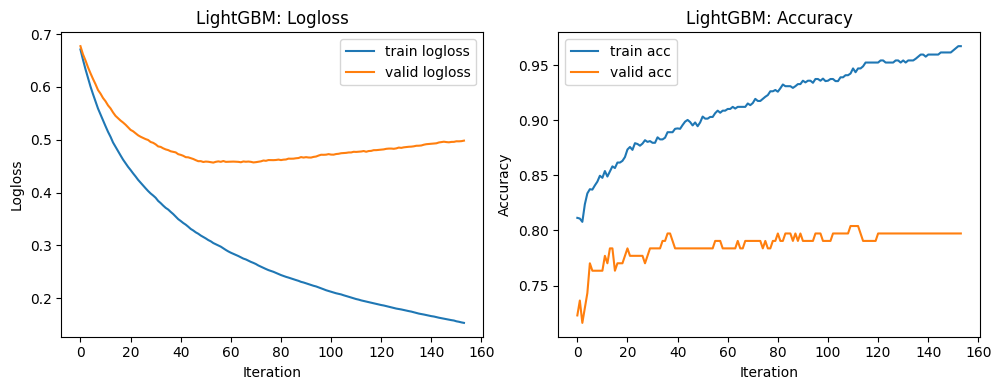

In [92]:
from lightgbm import LGBMClassifier, early_stopping, record_evaluation
import numpy as np
import matplotlib.pyplot as plt

evals_result = {}
LightGBM_non = LGBMClassifier(
    n_estimators=2000,
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.05,
    feature_fraction=0.9,     
    bagging_fraction=0.9,     
    bagging_freq=1,           
    reg_lambda=1.0,
    objective="binary",
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

LightGBM_non.fit(
    X_tr_proc, y_tr,
    eval_set=[(X_tr_proc, y_tr), (X_val_proc, y_val)],
    eval_names=["train","valid"],
    eval_metric=["binary_logloss","binary_error"],
    callbacks=[
        early_stopping(stopping_rounds=100, first_metric_only=True),
        record_evaluation(evals_result)
    ]
)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# ---- 子图 1：Logloss ----
axes[0].plot(evals_result['train']['binary_logloss'], label='train logloss')
axes[0].plot(evals_result['valid']['binary_logloss'], label='valid logloss')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Logloss')
axes[0].set_title('LightGBM: Logloss')
axes[0].legend()

# ---- 子图 2：Accuracy ----
train_acc = 1 - np.array(evals_result['train']['binary_error'])
valid_acc = 1 - np.array(evals_result['valid']['binary_error'])

axes[1].plot(train_acc, label='train acc')
axes[1].plot(valid_acc, label='valid acc')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('LightGBM: Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

## LightGBM（distributed）
LightGBM CLI/Dask/Ray/Spark

In [93]:
from lightgbm.dask import DaskLGBMClassifier
from dask.distributed import Client, LocalCluster
import dask.array as da

# Start the local distributed cluster
cluster = LocalCluster()
client = Client(cluster)

LightGBM = DaskLGBMClassifier(
    n_estimators=600,
    num_leaves=31,
    learning_rate=0.05,
    feature_fraction=0.9,   
    bagging_fraction=0.9, 
    bagging_freq=1,
    reg_lambda=1.0,
    objective="binary",
    class_weight="balanced",
    random_state=42
)

/Users/shangxingzhe/Tools/venvs/py_3.11_env/lib/python3.11/site-packages/distributed/node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57635 instead
  warnings.warn(


## 交叉验证与评估

In [94]:
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             accuracy_score, roc_auc_score, roc_curve)

In [95]:
# Define evaluation indicators
scorers = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

In [96]:
from sklearn.pipeline import Pipeline

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

def run_cv_and_summary(estimator, X, y, name):
    res = cross_validate(
        estimator, X, y,
        scoring=scorers,
        cv=cv,
        n_jobs=-1,
        return_train_score=False,
        return_estimator=False
    )
    summary = {
        "model": name,
        "accuracy": np.mean(res["test_accuracy"]),
        "precision": np.mean(res["test_precision"]),
        "recall": np.mean(res["test_recall"]),
        "f1": np.mean(res["test_f1"]),
        "roc_auc": np.mean(res["test_roc_auc"]),
        "fit_time(s)": np.mean(res["fit_time"]),
        "score_time(s)": np.mean(res["score_time"])
    }
    return pd.DataFrame([summary])


xgb_cv_est = Pipeline([
    ("prep", preprocess),  
    ("clf", clone(XGBoost).set_params(early_stopping_rounds=None, eval_metric="logloss"))
])

lgb_cv_est = Pipeline([
    ("prep", preprocess),
    ("clf", clone(LightGBM_non))
])

## 开始训练

In [97]:
# 4.2 Cross-validation (XGBoost/LightGBM is non-distributed)
cv_xgb = run_cv_and_summary(xgb_cv_est, X_train, y_train, "XGBoost")
cv_lgb = run_cv_and_summary(lgb_cv_est, X_train, y_train, "LightGBM (single-node)")

cv_table = pd.concat([cv_xgb, cv_lgb], ignore_index=True)
print("Cross-validation results:")
print(cv_table.round(3).to_string())

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will b

## 

In [98]:
from dask.distributed import Client, LocalCluster
import dask.array as da
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


 # 4.3 Distributed LightGBM (Single Test Set Evaluation)）
# Convert the local NumPy data into a Dask Array and then use .persist()
X_train_da = da.from_array(X_train_proc, chunks=(200, X_train_proc.shape[1]))
y_train_da = da.from_array(y_train.values, chunks=(200,))
X_test_da  = da.from_array(X_test_proc,  chunks=(200, X_test_proc.shape[1]))

# Distributed LightGBM Training
t0 = time.time()
LightGBM.fit(X_train_da, y_train_da)
train_time = time.time() - t0

# Distributed Prediction
# In a distributed environment, reasoning
t1 = time.time()
y_prob = LightGBM.predict_proba(X_test_da).compute()[:, 1]
y_pred = (y_prob >= 0.5).astype(int)
pred_time = time.time() - t1

# parameter
dist = {
    "model": "LightGBM (Distributed)",
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_prob),
    "fit_time(s)": train_time,
    "score_time(s)": pred_time
}
dist_df = pd.DataFrame([dist])
# 3. Merge all the model result tables
final_table = pd.concat([cv_table, dist_df], ignore_index=True)
print(final_table.round(3).to_string())

Finding random open ports for workers


/Users/shangxingzhe/Tools/venvs/py_3.11_env/lib/python3.11/site-packages/lightgbm/dask.py:549: UserWarning: Parameter n_jobs will be ignored.
  _log_warning(f"Parameter {param_alias} will be ignored.")


[LightGBM] [Info] Trying to bind port 57692...
[LightGBM] [Info] Binding port 57692 succeeded
[LightGBM] [Info] Trying to bind port 57690...
[LightGBM] [Info] Binding port 57690 succeeded
[LightGBM] [Info] Listening...
[LightGBM] [Info] Listening...
[LightGBM] [Warning] Connecting to rank 3 failed, waiting for 200 milliseconds
[LightGBM] [Warning] Connecting to rank 3 failed, waiting for 200 milliseconds
[LightGBM] [Info] Trying to bind port 57693...
[LightGBM] [Info] Binding port 57693 succeeded
[LightGBM] [Info] Trying to bind port 57691...
[LightGBM] [Info] Binding port 57691 succeeded
[LightGBM] [Info] Listening...
[LightGBM] [Info] Listening...
[LightGBM] [Info] Connected to rank 1
[LightGBM] [Info] Connected to rank 2
[LightGBM] [Info] Connected to rank 3
[LightGBM] [Info] Local rank: 0, total number of machines: 4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample

# Task B

在 Task A 中你并没有真正“填补”缺失值到 DataFrame 中，而是：  
	•创建了一个 ColumnTransformer + SimpleImputer 的预处理器，  
	•预处理器是在 transform() 时 才对数据进行了缺失填补，  
	•但是并没有把填补后的结果写回到原始 DataFrame。  


In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import time

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [100]:
# Display basic information about the processed DataFrame
print("Shape:", df_model.shape)
print("Columns:", list(df_model.columns))
print("Target balance:\n", df_model["target"].value_counts(normalize=True).round(3))

Shape: (920, 15)
Columns: ['age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
Target balance:
 target
1    0.553
0    0.447
Name: proportion, dtype: float64


### 2.2 EDA

In [101]:
# miss rate
na_rate = df_model.isna().mean().sort_values(ascending=False)
print("Missing rate (modeling view):")
print(na_rate[na_rate > 0])

Missing rate (modeling view):
ca          0.664130
thal        0.528261
slope       0.335870
fbs         0.097826
oldpeak     0.067391
trestbps    0.064130
thalch      0.059783
exang       0.059783
chol        0.032609
restecg     0.002174
dtype: float64


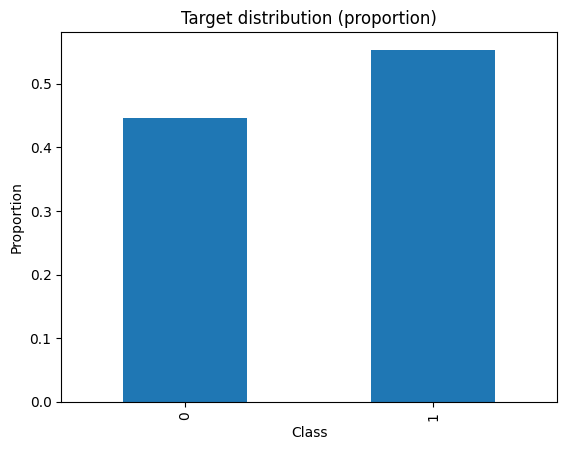

In [102]:
# Target distribution plot
ax = df_model["target"].value_counts(normalize=True).sort_index().plot(kind="bar")
ax.set_title("Target distribution (proportion)")
ax.set_xlabel("Class"); 
ax.set_ylabel("Proportion")
plt.show()

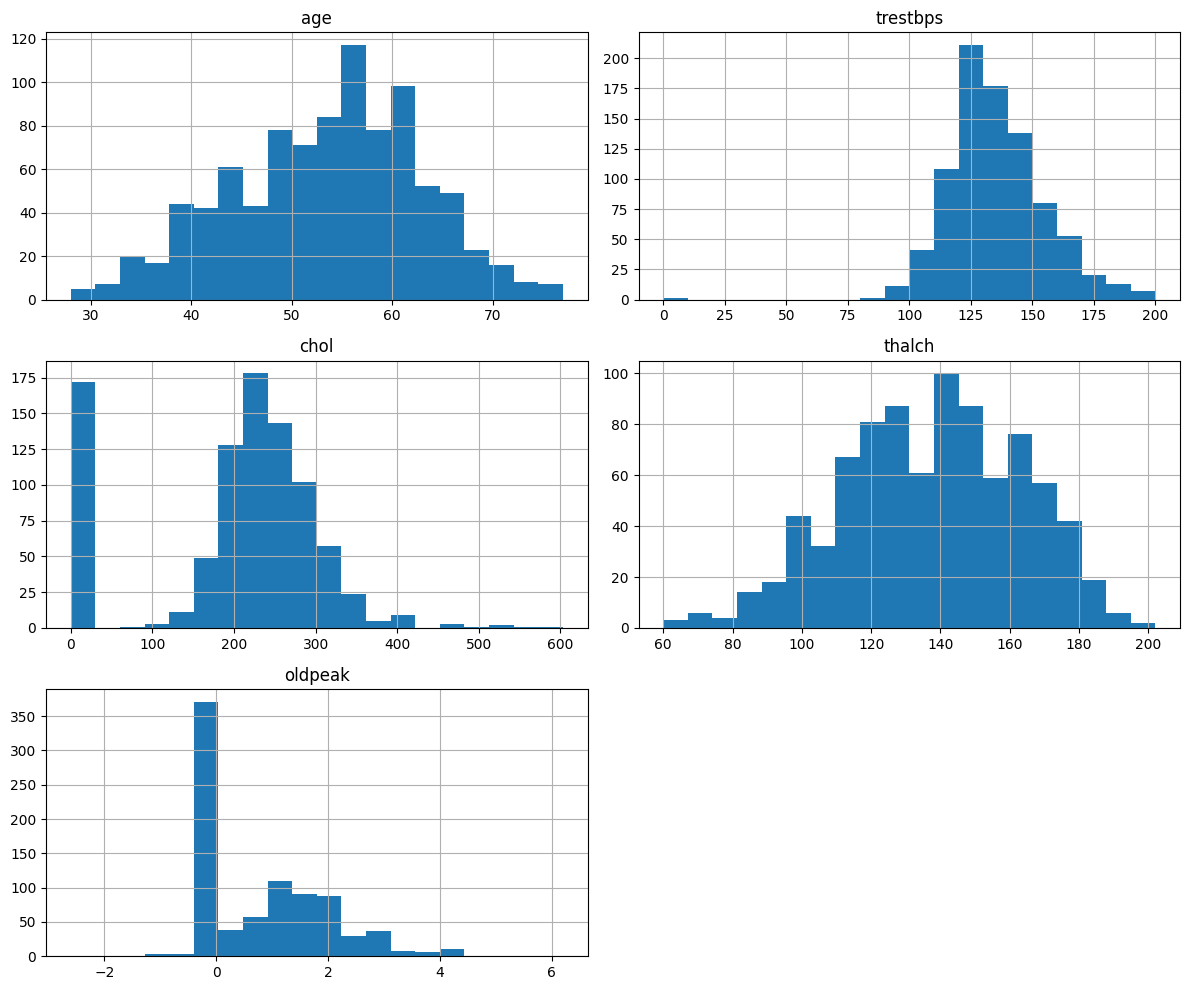

In [103]:
# Histogram of numerical distribution
num_cols = df_model.select_dtypes(include=["number"]).columns.tolist()
if "target" in num_cols:
    num_cols.remove("target")

df_model[num_cols].hist(bins=20, figsize=(12,10))
plt.tight_layout(); plt.show()

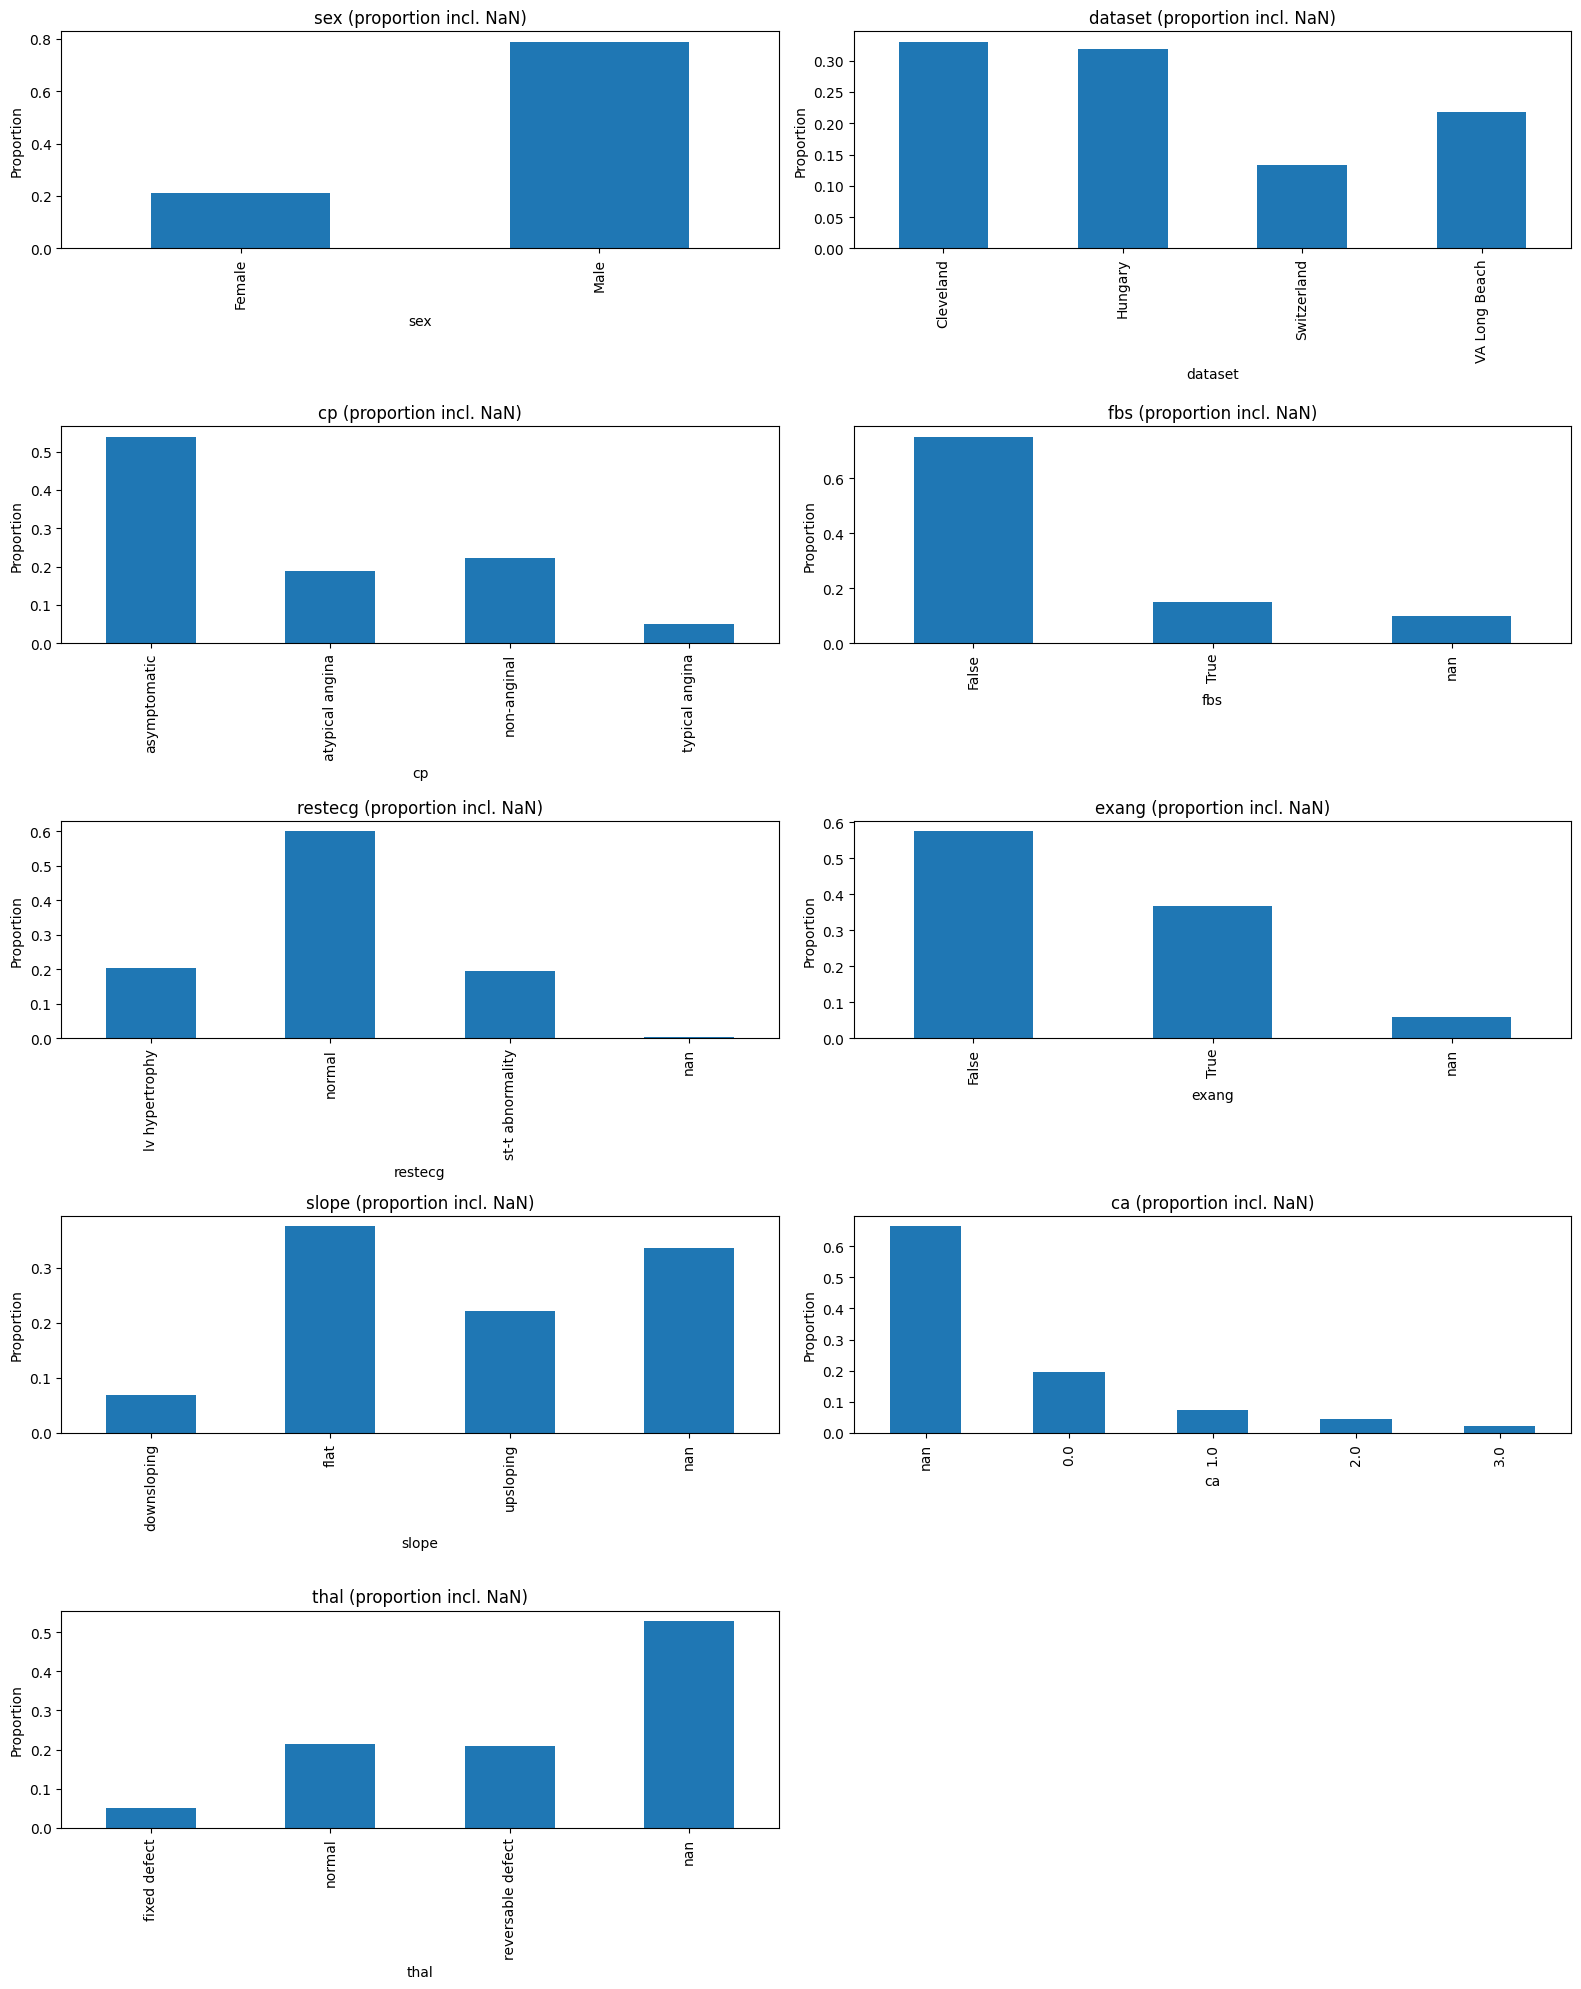

In [119]:
import math
import matplotlib.pyplot as plt

# 提取分类字段
cat_cols = df_model.select_dtypes(include=["category", "object"]).columns.tolist()

# 定义行列布局（可调整）
n_feats = len(cat_cols)
n_cols = 2  # 每行两个图
n_rows = math.ceil(n_feats / n_cols)

# 创建大画布
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 4 * n_rows))

# 处理只有一个特征的情况
if n_feats == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# 遍历绘图
for i, col in enumerate(cat_cols):
    ax = axes[i]
    vc = (df_model[col]
          .value_counts(dropna=False, normalize=True)
          .sort_index())
    vc.plot(kind="bar", ax=ax)
    ax.set_title(f"{col} (proportion incl. NaN)")
    ax.set_xlabel(col)
    ax.set_ylabel("Proportion")

# 隐藏多余空白子图
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

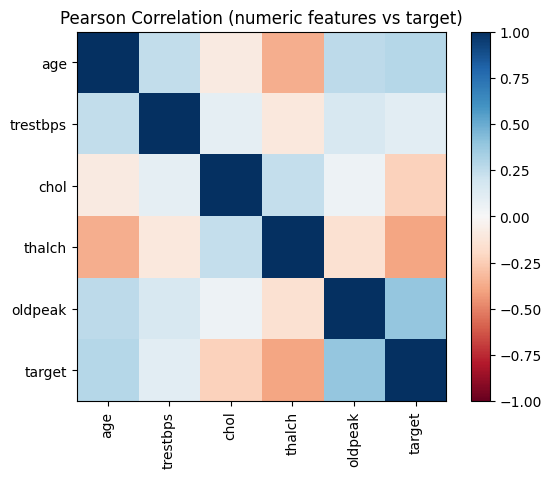

In [105]:
# Corresponding heat map
corr = df_model[num_cols + ["target"]].corr(numeric_only=True)
plt.imshow(corr, cmap="RdBu", vmin=-1, vmax=1)
plt.colorbar(); plt.title("Pearson Correlation (numeric features vs target)")
plt.xticks(range(corr.shape[1]), corr.columns, rotation=90)
plt.yticks(range(corr.shape[1]), corr.columns)
plt.show()

In [106]:
X_train_proc_lgb = preprocess_tr.transform(X_train)
X_test_proc_lgb  = preprocess_tr.transform(X_test)
feature_names_lgb = preprocess_tr.get_feature_names_out()

print("LightGBM feature dim:", X_train_proc_lgb.shape[1])

LightGBM feature dim: 36


In [107]:
#Logistic Regression (non-tree model) + evaluation
lr = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    solver="liblinear",
    random_state=42,
)

t0 = time.time()
lr.fit(X_train_proc_lgb, y_train)
lr_train_time = time.time() - t0

def report(y_true, y_prob, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "AUROC": roc_auc_score(y_true, y_prob),
    }

In [108]:
t0 = time.time()
LightGBM_non.fit(X_train_proc_lgb, y_train)
lgb_train_time = time.time() - t0

t1 = time.time()
proba_lgb = LightGBM_non.predict_proba(X_test_proc_lgb)[:, 1]
pred_lgb = (proba_lgb >= 0.5).astype(int)
lgb_pred_time = time.time() - t1

lgb_scores = report(y_test, proba_lgb, pred_lgb) | {
    "Train time(s)": lgb_train_time,
    "Predict time(s)": lgb_pred_time,
}

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 407, number of negative: 329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM

In [109]:
t1 = time.time()
proba_lr = lr.predict_proba(X_test_proc_lgb)[:, 1]
pred_lr = (proba_lr >= 0.5).astype(int)
lr_pred_time = time.time() - t1

lr_scores = report(y_test, proba_lr, pred_lr) | {
    "Train time(s)": lr_train_time,
    "Predict time(s)": lr_pred_time,
}

# 性能对比表
perf_table_taskB = pd.DataFrame(
    [
        {"Model": "LightGBM_non", **lgb_scores},
        {"Model": "LogisticRegression", **lr_scores},
    ]
)

print("\nTask B - Test Performance:")
print(perf_table_taskB.round(3).to_string(index=False))


Task B - Test Performance:
             Model  Accuracy  Precision  Recall    F1  AUROC  Train time(s)  Predict time(s)
      LightGBM_non     0.848      0.856   0.873 0.864  0.889          8.576            0.003
LogisticRegression     0.853      0.857   0.882 0.870  0.927          0.003            0.000


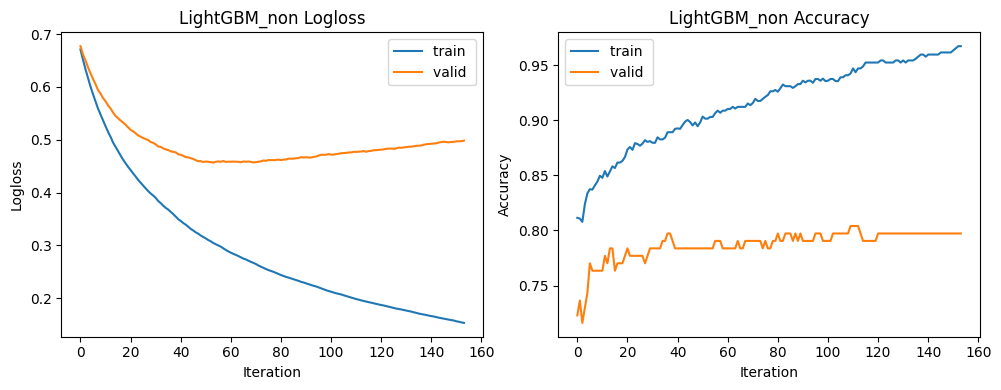

In [121]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Logloss 
axes[0].plot(evals_result["train"]["binary_logloss"], label="train ")
axes[0].plot(evals_result["valid"]["binary_logloss"], label="valid ")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Logloss")
axes[0].set_title("LightGBM_non Logloss")
axes[0].legend()

# Accuracy 
train_acc = 1.0 - np.array(evals_result["train"]["binary_error"])
valid_acc = 1.0 - np.array(evals_result["valid"]["binary_error"])
axes[1].plot(train_acc, label="train ")
axes[1].plot(valid_acc, label="valid ")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("LightGBM_non Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()

In [112]:
import shap
shap.initjs()

# Take a sample of the test samples for visualization purposes
sample_n = min(200, X_test_proc_lgb.shape[0])
idx = np.random.RandomState(42).choice(X_test_proc_lgb.shape[0], sample_n, replace=False)
X_shap = X_test_proc_lgb[idx]
# LightGBM(Tree) - TreeExplainer
expl_lgb = shap.TreeExplainer(LightGBM_non)
sv_lgb = expl_lgb.shap_values(X_shap)

/Users/shangxingzhe/Tools/venvs/py_3.11_env/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


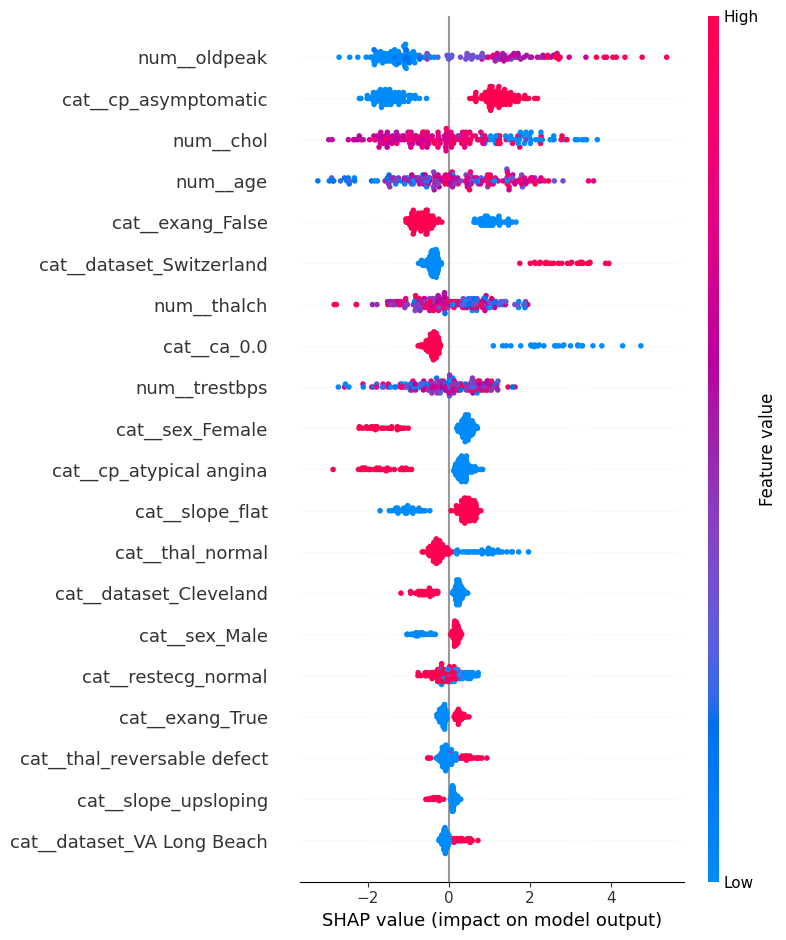

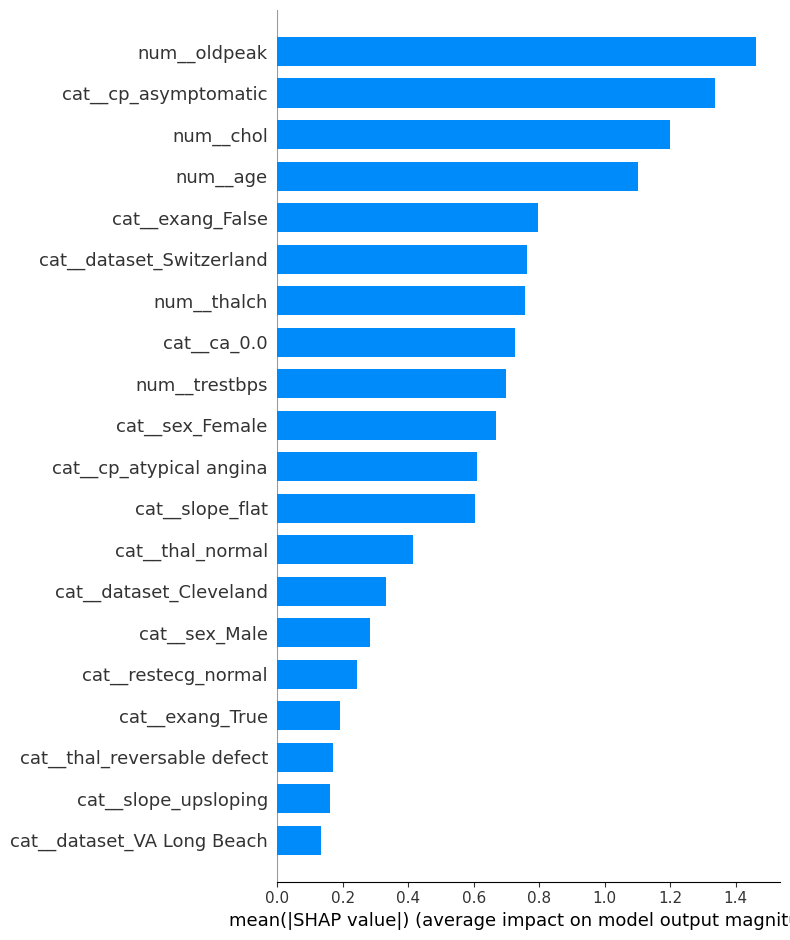

In [123]:
if isinstance(sv_lgb, list):
    sv_lgb = sv_lgb[1]

# Global significance（beeswarm & bar）
shap.summary_plot(sv_lgb, X_shap, feature_names=feature_names_lgb, show=True)
shap.summary_plot(
    sv_lgb,
    X_shap,
    feature_names=feature_names_lgb,
    plot_type="bar",
    show=True,
)

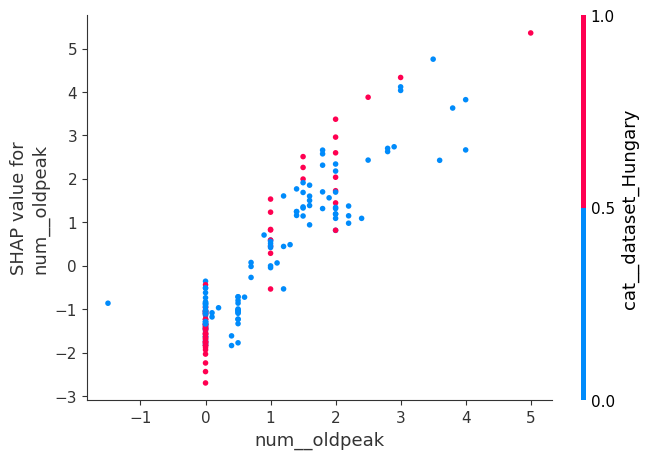

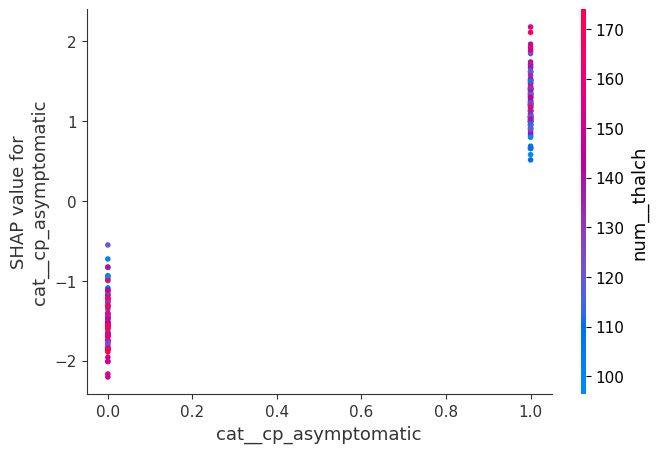

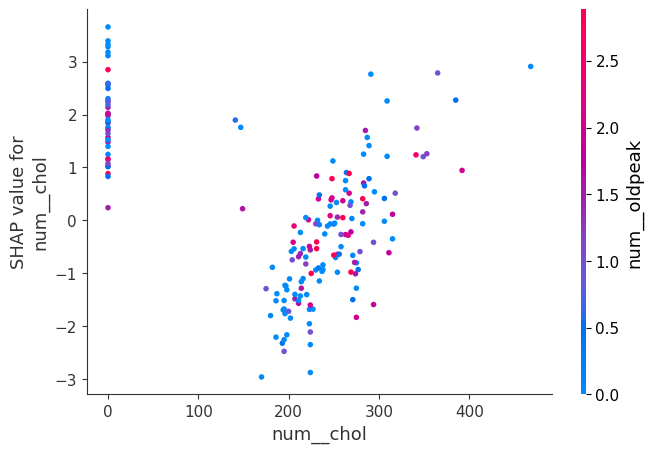

In [114]:
# Dependency graph
# Obtain the global importance ranking index
mean_abs = np.abs(sv_lgb).mean(0)
top_idx = np.argsort(-mean_abs)[:3]
for i in top_idx:
    shap.dependence_plot(int(i), sv_lgb, X_shap, feature_names=feature_names_lgb, show=True)


In [115]:
# 6.2 Logistic Regression(Non-tree) - LinearExplainer
# Use the processed features of the training set as the reference background distribution
expl_lr = shap.LinearExplainer(
    lr,
    X_train_proc_lgb,           # background data
    feature_perturbation="interventional",
)
sv_lr = expl_lr.shap_values(X_shap)

# 保险起见，如果返回 list，同样取正类
if isinstance(sv_lr, list):
    sv_lr = sv_lr[1]

/Users/shangxingzhe/Tools/venvs/py_3.11_env/lib/python3.11/site-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


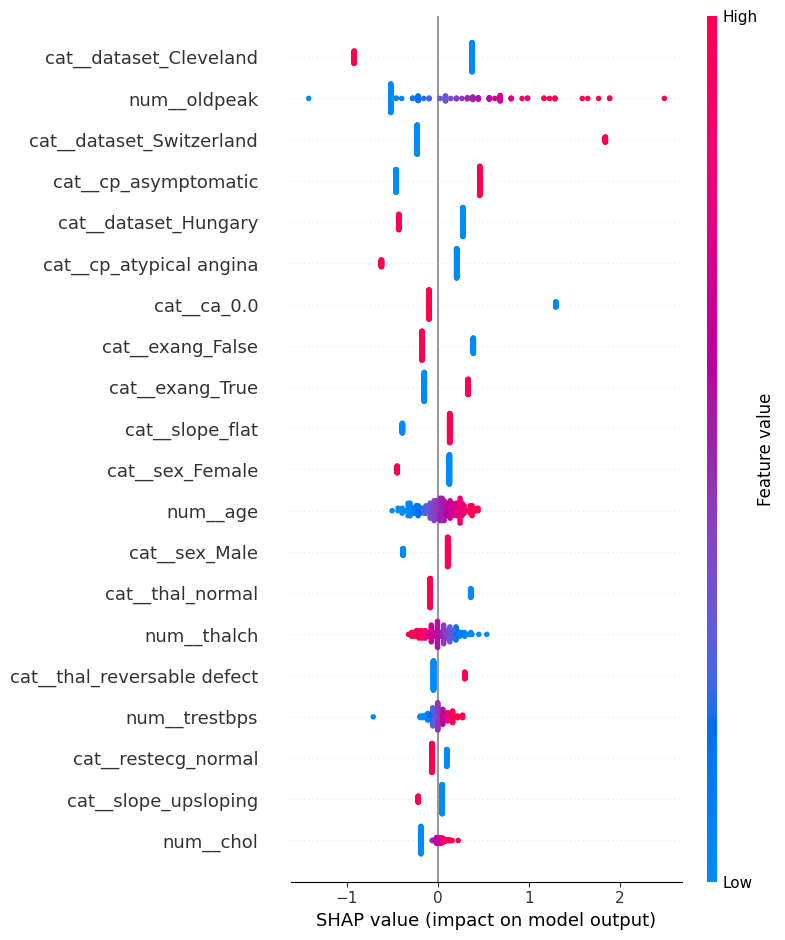

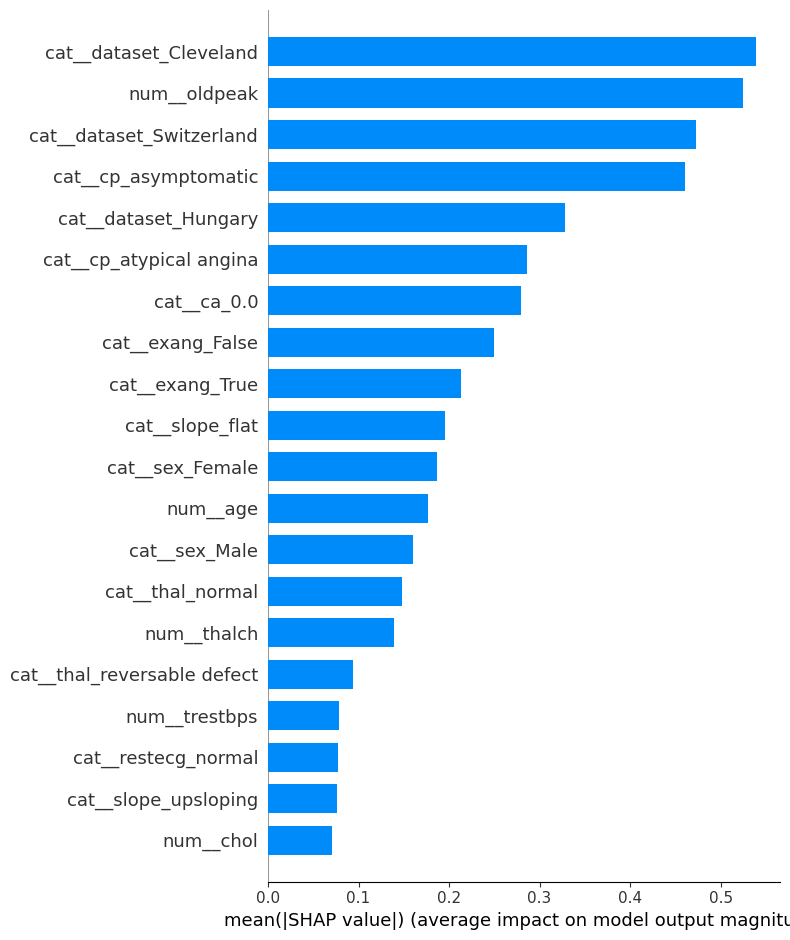

In [ ]:
shap.summary_plot(sv_lr, X_shap, feature_names=feature_names_lgb, show=True)
shap.summary_plot(
    sv_lr,
    X_shap,
    feature_names=feature_names_lgb,
    plot_type="bar",
    show=True,
)